# Open Source GIS

Much of the information included in this notebook is derived from [*Geocomputation with R*](https://r.geocompx.org/index.html) by Lovelace, Nowosad, and Muenchow.

## Introduction

In this notebook, we are going to investigate the ability of open-source computer programming languages to perform GIS techniques. In particular, this notebook will make use of the R coding language, which is a language and environment for statistical computing and graphics.

Over the last few decades, free and open source software for geospatial analysis has increased dramatically. Open source Geographic Information Systems (GIS), such as QGIS, have made geographic analysis accessible worldwide. But these GIS are reliant on graphical user interfaces (GUIs), which makes reproducibility---a tenant of science---difficult. R and Python, by contrast, emphasize the command line interface (CLI), which lends itself to easy reporducible results.

| Attribute        | Desktop GIS (GUI)        | R                  |
| -----------      | -----------              | -----------
| Home Disciplines | Geography                | Computing, Statistics |
| Software focus.  | Graphical User Interface | Command line          |
| Reproducibility  | Minimal                  | Maximal               |

R makes use of a number of packages to perform geospatial analysis and act as a GIS. We will begin by loading some of the needed packages.

In [ ]:
options(warn=-1) # turn warnings off
library(sf) # simple features (vector data)
library(raster) # raster features
library(terra) # raster features
library(spData) # load geographic data
library(geojsonio)
library(tidyverse)

## Vectors (simple features)

The one package that we should focus a bit on is simple features (sf). Simple Features is a hierarchical data model that represents a wide range of geometry types. Of 18 geometry types supported by the specification, only 7 are used in the vast majority of geographic research (see image below).

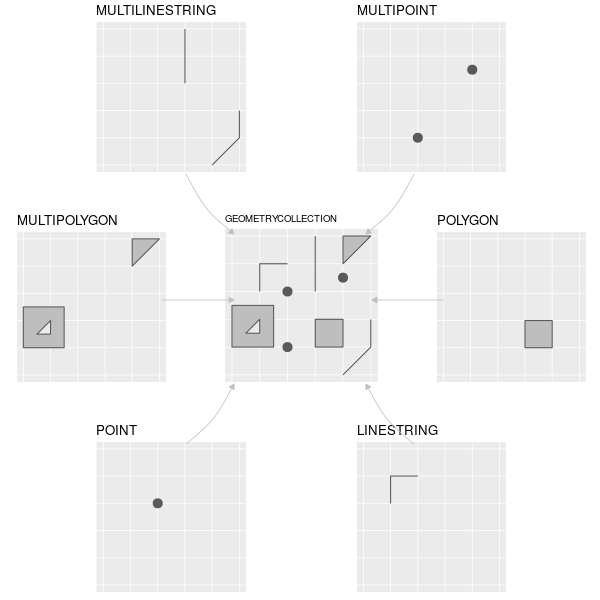

sf can represent all common vector geometry types (raster data classes are not supported by sf): points, lines, polygons and their respective ‘multi’ versions (which group together features of the same type into a single feature). sf also supports geometry collections, which can contain multiple geometry types in a single object.

We will use the world dataset provided by spData, loaded at the beginning of this chapter, to show what sf objects are and how they work. world is an ‘sf data frame’ containing spatial and attribute columns, the names of which are returned by the function names()

In [ ]:
class(world)

In [ ]:
names(world)

In [ ]:
head(world) # first six rows of the data set

The contents of this geom column give sf objects their spatial powers: world$geom is a ‘list column’ that contains all the coordinates of the country polygons. 

Nicely, sf objects can be plotted quickly with the function plot().

In [ ]:
plot(world)

Individual aspects of the dataset can be plotted individually using a subset function, as seen below. This allows for the isolation of fields.

In [ ]:
plot(world["region_un"])

But this map is not production quality. Clearly the legend does not label each region sufficiently and there are no scales or north arrows. Enter the tmap package.

With the tmap package, thematic maps can be generated with great flexibility. The syntax for creating plots is similar to other R-related packages, but tailored to maps.

In [ ]:
library(tmap)

In order to plot it in tmap, you first need to specify it with tm_shape. Layers can be added with the + operator, in this case tm_polygons. There are many layer functions in tmap, which can easily be found in the documentation by their tm_ prefix. 

See also ?'tmap-element'.

In [ ]:
?'tmap-element'

In [ ]:
tm_shape(world) +
    tm_polygons("region_un", title = 'World Region') +
    tm_scale_bar(position=c("right", "bottom")) +
    tm_layout(frame = TRUE)

### Review Question 1

Which aspects of a proper map are seen above? Which aspects are missing?

**Insert answer here**

This map is pretty good, except the legend is difficult to see over Antarctica. We can adjust the settings for the legend through the legend.position argument in tm_layout(). We can also add a north arrow through the tm_compass() function.

In [ ]:
tm_shape(world) +
    tm_polygons("region_un", title = 'World Region') +
    tm_scale_bar(position=c("right", "bottom")) +
    tm_compass(type = 'arrow', position=c(.88, .12)) +
    tm_layout(frame = TRUE, legend.position = c(0, .18))

The power of performing geospatial analysis in a programming language, is the ease with which you can analyze the non-spatial data attached to each data set.

More broadly, treating geographic objects as regular data frames with spatial powers has many advantages, especially if you are already used to working with data frames. The commonly used summary() function, for example, provides a useful overview of the variables within the world object.

In [ ]:
summary(world$pop)

Even more useful than the summary(), mean(), max(), or min() functions is the ability of programming languages to seamlessly move between spatial and non-spatial data analysis. 

In R, the most powerful data manipulation package is the dplyr package. This package allows for us to create secondary data sets to analyze.

In [ ]:
library(dplyr)

For instance, let's try to find the all of the countries in the world with a population over 10 million people.

In [ ]:
world2 <- world %>%
    filter(pop > 10000000)

world2

Now, can we see which continent or world region has the highest number of countries with a population over 10 million people.

In [ ]:
world3 <- world2 %>%
    group_by(continent) %>%
    summarize(Number = n())

world3

### Review Question 2

Which continent has the highest number of countries with a population over 10 million people?

**Insert answer here**

Now that we know this information, we can plot these results. 

If we immediate plot the results, we get the map below.

In [ ]:
tm_shape(world3) +
tm_polygons("Number")

This is clearly a map of only those countries that have a population over 10 million people. 

We want the entire continents to be shaded, so we have create a continents dataframe and join it with the world3 dataframe.

In [ ]:
continents <- world %>% 
 mutate(continent = as.character(continent)) %>%
  group_by(continent) %>% 
  summarize()

head(continents)

In [ ]:
plot(continents)

In [ ]:
world3$geom = NULL
world3 <- data.frame(world3)

head(world3)

So, now we have created two dataframes that we are joining. One is an attribute table (world3) with information on continent and the number of countries over 10 million people. One is a simple features dataframe (spatial table) with infomation including the geometry of the continents.

In [ ]:
world3<- merge(world3, continents, by = "continent") %>%
    st_as_sf()

head(world3)

Let's plot.

In [ ]:
tm_shape(world3) +
    tm_polygons("Number", n = 5, breaks = c(0, 5, 10, 15, 30, 40)) +
    tm_scale_bar(position=c(.6, .01)) +
    tm_compass(type = 'arrow', position=c(.85, .12)) +
    tm_layout(frame = TRUE, legend.position = c(0, .1))

Looking at the output of the previous few lines of code, you can see that most of the objects we are working with are considered MULTIPOLYGONS in the sf environment. To clear up any confusion that may exist regarding this spatial object definiton, below is a figure showing how R interprets a POINT, LINESTRING, and POLYGON and a figure showing how R interprets MULTIPOINT, MULTILINESTRING, and MULTIPOLYGON.

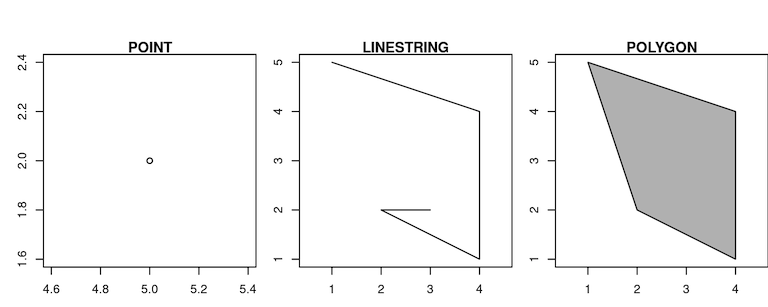

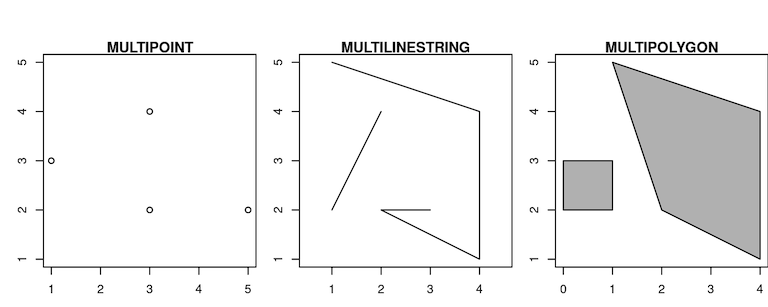

## Rasters

The spatial raster data model represents the world with the continuous grid of cells.

The raster data model usually consists of a raster header and a matrix (with rows and columns) representing equally spaced cells (often also called pixels). The raster header defines the extent via the number of columns, the number of rows and the cell size resolution. Starting from the raster origin (wherever that exists), we can easily access and modify each single cell by either using the ID of a cell. In contrast to vector data, the cell of one raster layer can only hold a single value---whether numeric or categorical.

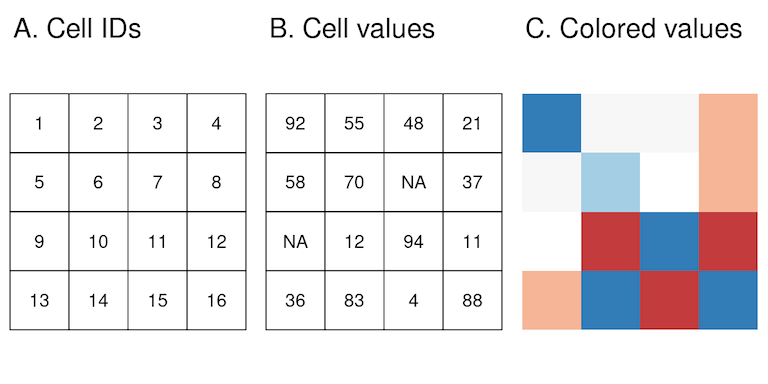

Raster maps usually represent continuous phenomena such as elevation, temperature, population density or spectral data. Discrete features such as soil or land-cover classes can also be represented in the raster data model.

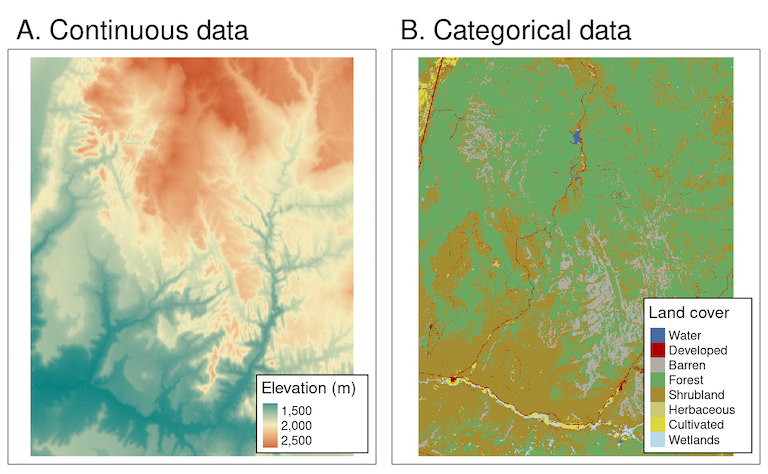

To investigate raster analysis in R, we will use data from the spDataLarge package from Zion National Park (Utah, USA).

In [ ]:
library(spDataLarge)
library(terra)
raster_filepath = system.file("raster/srtm.tif", package = "spDataLarge")
my_rast = rast(raster_filepath)

Typing the name of the raster into the console, will print out the raster header (dimensions, resolution, extent, CRS) and some additional information (class, data source, summary of the raster values):

In [ ]:
my_rast

Like with other data models in R, we can try to figure out more information about this raster through basic data analysis functions like range() and hist().

In [ ]:
range(values(my_rast))

hist(my_rast,
     main = "Distribution of surface elevation values",
     xlab = "Elevation (meters)", ylab = "Frequency",
     col = "springgreen")

Similar to the sf package, terra also provides plot() methods for its own classes

In [ ]:
plot(my_rast)

### Review Question 3

In which general direction in this image are the highest elevations?

**Insert answer here**

There are several other approaches for plotting raster data in R that are outside the scope of this section, including:

* plotRGB() function from the terra package to create a Red-Green-Blue plot based on three layers in a SpatRaster object
 
* Packages such as tmap to create static and interactive maps of raster and vector objects

* Functions, for example levelplot() from the rasterVis package, to create facets, a common technique for visualizing change over time

We will take a quick look at the rasterVis package and levelplot() now.

In [ ]:
library(rasterVis)
levelplot(my_rast)

As we can see, the levelplot function creates more prodcution-ready figures, however, like plotting with the tmap package, there are more arguments that need to be entered into to code to customize our output.

See also ?'levelplot'.

In [ ]:
?'levelplot'

In [ ]:
zpadding <- list(layout.heights= list(top.padding=0, bottom.padding=0),
                  layout.widths= list(left.padding=0, right.padding=0)) # workaround for resizing of plot

levelplot(my_rast, col.regions = rev(terrain.colors(100)), margin = FALSE, par.settings=zpadding)

Now our image is the same the plot() function, but with better labels and more appropriate axis information.

But raster analysis is often more than just plotting an image. In class, we have discussed several forms of map algebra that can be applied to raster data. Perhaps the simplest forms of map algebra are simple mathematical, boolean, and logical operators.

In [ ]:
my_rast2 <- my_rast
values(my_rast2) <- values(my_rast2) + 1000
plot(my_rast2)

### Review Question 4

What happened to the values of the color ramp after this mathematical operator is applied?

**Insert answer here**

In [ ]:
my_rast3 <- my_rast > 2000 & my_rast < 3000
plot(my_rast3)

In [ ]:
my_rast4 <- my_rast < 1500
plot(my_rast4)

Rasters can also be created from scratch using the raster() or rast() argument.

In [ ]:
library(raster)

xmn = -124.6813; xmx = -67.00742; ymn = 24.85; ymx = 49.38323; res = 0.6
r = raster(xmn = xmn, xmx = xmx,
           ymn = ymn, ymx = ymx,
           resolution = res)
ncell(r); nrow(r); ncol(r)

The raster above consists of 3936 cells (41 rows and 96 columns specified by nrows and ncols). To visualize what this r object looks like across space, we can transform or convert the object to a spatail---or vector---object.

In [ ]:
Rsp = as(r, "SpatialPolygonsDataFrame")
sfR = st_as_sf(Rsp)
sfT = st_transform(sfR, crs = "+init=epsg:2163")

In [ ]:
library(USAboundaries)  

states <- us_states() %>%
  st_transform(crs = 2163) %>%
  mutate() %>% # fix error with 'ag' column
  rename(st = state_abbr)

states <- states %>%
  filter(!st %in% c("AK", "PR", "HI"))

In [ ]:
tm_shape(states, projection ="+init=epsg:2163") +
  tm_borders(alpha = 0.5) +
  tm_fill(col = "white") +
tm_shape(sfT) +
  tm_borders(alpha = 0.2)

As you can see, the raster covers the entire contiguous United States at a resolution of 0.6$^{\circ}$. We could use this raster to map any number of things across the surface of the United States.

## Raster-Vector Interactions

Many geographic data projects involve integrating data from many different sources, such as remote sensing images (rasters) and administrative boundaries (vectors). Often the extent of input raster datasets is larger than the area of interest. In this case, raster cropping and masking are useful for unifying the spatial extent of input data. Both operations reduce object memory use and associated computational resources for subsequent analysis steps, and may be a necessary preprocessing step before creating attractive maps involving raster data.

We will use two objects to illustrate raster cropping:

* A SpatRaster object srtm representing elevation (meters above sea level) in south-western Utah
* A vector (sf) object zion representing Zion National Park

In [ ]:
srtm = rast(system.file("raster/srtm.tif", package = "spDataLarge"))
zion = read_sf(system.file("vector/zion.gpkg", package = "spDataLarge"))
zion = st_transform(zion, crs(srtm))

We use crop() from the terra package to crop the srtm raster. The function reduces the rectangular extent of the object passed to its first argument based on the extent of the object passed to its second argument.

In [ ]:
srtm_cropped = crop(srtm, zion)
plot(srtm_cropped)

Related to crop() is the terra function mask(), which sets values outside of the bounds of the object passed to its second argument to NA. The following command therefore masks every cell outside of the Zion National Park boundaries.

In [ ]:
srtm_masked = mask(srtm, zion)
plot(srtm_masked)

Importantly, we want to use both crop() and mask() together in most cases. This combination of functions would (a) limit the raster’s extent to our area of interest and then (b) replace all of the values outside of the area to NA.

In [ ]:
srtm_cropped = crop(srtm, zion)
srtm_final = mask(srtm_cropped, zion)
plot(srtm_final)

tmap also allows for the mapping of raster data using the tm_raster argument.

In [ ]:
tm_shape(srtm_cropped) +
tm_raster(n = 7, palette = rev(terrain.colors(10)), 
          style = "cont", legend.reverse = TRUE, title = "Elevation (m)") +
    tm_scale_bar(position=c(.62, .01)) +
    tm_compass(type = 'arrow', position=c(.85, .07)) +
    tm_layout(legend.outside = TRUE, frame = FALSE)

Now let's add the outline of Zion National Park.

In [ ]:
tm_shape(srtm_cropped) +
tm_raster(n = 7, palette = rev(terrain.colors(10)), 
          style = "cont", legend.reverse = TRUE, title = "Elevation (m)") +
tm_shape(zion) +
tm_borders(col = 'black', lwd = 1.5) +
    tm_scale_bar(position=c(.025, .01)) +
    tm_compass(type = 'arrow', position=c(.015, .07)) +
    tm_layout(legend.outside = TRUE, frame = FALSE)

## Interactive Mapping

While static and animated maps can enliven geographic datasets, interactive maps can take them to a new level. Interactivity can take many forms, the most common and useful of which is the ability to pan around and zoom into any part of a geographic dataset overlaid on a ‘web map’ to show context. Less advanced interactivity levels include popups which appear when you click on different features, a kind of interactive label (think of ULM's current campus map).

The most important type of interactivity, however, is the display of geographic data on interactive or ‘slippy’ web maps. The release of the leaflet package in 2015 revolutionized interactive web map creation from within R and a number of packages have built on these foundations adding new features (e.g., leaflet.extras) and making the creation of web maps as simple as creating static maps (e.g., mapview and tmap). This section illustrates each approach in the opposite order. We will explore how to make slippy maps with tmap (the syntax of which we have already learned), mapview and finally leaflet (which provides low-level control over interactive maps).

A unique feature of tmap is its ability to create static and interactive maps using the same code. Maps can be viewed interactively at any point by switching to view mode, using the command tmap_mode("view"). This is demonstrated in the code below, which creates an interactive map of New Zealand based on the tmap object map_nz.

In [ ]:
map_nz = tm_shape(nz) + tm_polygons()

In this Jupyter Notebook the use of tmap_leaflet() is required to see the interactive map.

In [ ]:
tmap_mode("view")
tmap_leaflet(map_nz)

Now that the interactive mode has been ‘turned on’, all maps produced with tmap_leaflet will launch. Notable features of this interactive mode include the ability to specify the basemap with tm_basemap() (or tmap_options()) as demonstrated below:

In [ ]:
map_nz2 <- map_nz + 
    tm_basemap(leaflet::providers$OpenTopoMap)

tmap_leaflet(map_nz2)

An impressive and little-known feature of tmap’s view mode is that it also works with faceted plots. 

The argument sync in tm_facets() can be used in this case to produce multiple maps with synchronized zoom and pan settings, as illustrated below:

In [ ]:
world_coffee = left_join(world, coffee_data, by = "name_long")

facets = c("coffee_production_2016", "coffee_production_2017")

coffee_map <- tm_shape(world_coffee) + 
    tm_polygons(facets) + 
    tm_facets(nrow = 1, sync = TRUE)

tmap_leaflet(coffee_map)

And with this comes the end our brief introduction to the world of open source GIS through a programming language.